In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
# Prepare Data
train_val_data_path = f'..\\..\\train_data_with_car_type.json'
file_path = os.path.abspath(train_val_data_path)
json_data = pd.read_json(file_path, lines=True)
df = pd.DataFrame(json_data)
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   img_local      3983 non-null   object 
 1   price          3983 non-null   float64
 2   mileage        3983 non-null   int64  
 3   fuel_type      3983 non-null   object 
 4   gearbox        3983 non-null   object 
 5   year           3983 non-null   int64  
 6   model          3983 non-null   object 
 7   is_private     3983 non-null   bool   
 8   car_type_main  3983 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(5)
memory usage: 253.0+ KB
None
             img_local     price  mileage fuel_type       gearbox  year  \
0  619888553496191.jpg  255000.0        6    Diesel  Automatyczna  2023   
1  878738710972359.jpg  249600.0        5    Diesel  Automatyczna  2024   
2  325534139055352.jpg   52990.0   230000    Diesel  Automatyczna  2016   
3  586230984198372.jpg  149000.0

In [3]:
X = df.drop(columns=['price', 'img_local'])
y = df['price']

X = pd.get_dummies(X, columns=['fuel_type', 'gearbox', 'model'], drop_first=True)

scaler = StandardScaler()
X[['mileage', 'year']] = scaler.fit_transform(X[['mileage', 'year']])


In [4]:
a = X['car_type_main'].value_counts(dropna=False)
a

car_type_main
320d         265
520d         262
xDrive20d    199
318d         135
320i         134
            ... 
740iL          1
525xi          1
645Ci          1
sDrive30i      1
550e           1
Name: count, Length: 219, dtype: int64

In [5]:
#for car type main only
# if 'car_type_main' in X.columns:
#     car_type_columns=100
#     top_types = X['car_type_main'].value_counts().nlargest(car_type_columns).index
#     X['car_type_main'] = X['car_type_main'].apply(lambda x: x if x in top_types else 'Other')
#     X = pd.get_dummies(X, columns=['car_type_main'], drop_first=True)
X = pd.get_dummies(X, columns=['car_type_main'], drop_first=True)



In [6]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [7]:
# Trenowanie modelu
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [8]:
# Predykcja na zbiorze testowym
check_len=-1
y_pred = model.predict(X_test[:check_len])
mae = mean_absolute_error(y_test[:check_len], y_pred)
print(mae)
mape = np.mean(np.abs((y_test[:check_len] - y_pred) / y_test[:check_len])) * 100
print(mape)

#bez car_type_main
#23290.654173944746
#23.015994893527573

#z car_type_main i 40 car types
#18706.780385142614
#19.785837906679852

# z car_type_main i wszystkie car types
17852.978102485453
18.71417042577179


17852.978102485453
18.71417042577179


18.71417042577179

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
modelXGBoost = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10, 12],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Użycie GridSearchCV
grid_search = GridSearchCV(
    estimator=modelXGBoost,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Użyj MSE jako metryki oceny
    cv=5,  # Liczba podziałów walidacji krzyżowej
    verbose=1,
    n_jobs=-1  # Użycie wszystkich dostępnych rdzeni procesora
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10, 12],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [9]:
# Wczytanie modelu
from xgboost import XGBRegressor
grid_search = XGBRegressor()
grid_search.load_model('best_xgb_model.json')


y_pred = grid_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(mae)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(mape)

#z car type main
# 17872.489792713568
# 17.87790051732336

# z car type all
# 16666.09804229481
# 17.791677973908417

16644.981030518396
17.767506762227015


In [13]:
grid_search.best_estimator_.save_model('best_xgb_model.json')

In [11]:
# modelRFRGrid = RandomForestRegressor(random_state=42)

# # Definiowanie siatki hiperparametrów
# param_grid_RFR = {
#     'n_estimators': [100, 200, 300],         # Liczba drzew w lesie
#     'max_depth': [None, 10, 20, 30],         # Maksymalna głębokość drzew
#     'min_samples_split': [2, 5, 10],         # Minimalna liczba próbek do podziału w węźle
#     'min_samples_leaf': [1, 2, 4],           # Minimalna liczba próbek w liściu
#     'max_features': ['auto', 'sqrt', 'log2'] # Liczba cech przy rozważaniu podziału
# }

# grid_search_RFR = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid_RFR,
#     scoring='neg_mean_squared_error',  # Metryka oceny, negatywny MSE
#     cv=5,                              # Liczba podziałów walidacji krzyżowej
#     verbose=1,
#     n_jobs=-1                          # Użycie wszystkich dostępnych rdzeni procesora
# )

# grid_search_RFR.fit(X_train, y_train)

In [12]:
# check_len=-1
# y_pred = grid_search_RFR.predict(X_test[:check_len])
# mae = mean_absolute_error(y_test[:check_len], y_pred)
# print(mae)
# mape = np.mean(np.abs((y_test[:check_len] - y_pred) / y_test[:check_len])) * 100
# print(mape)

# Bez car type
#24010.760740878803
#23.711050426825125

#z car type:
#18562.88296526662
#19.96414724205388

In [25]:
len(y_test.to_numpy())

598

In [26]:
len(y_pred)

598

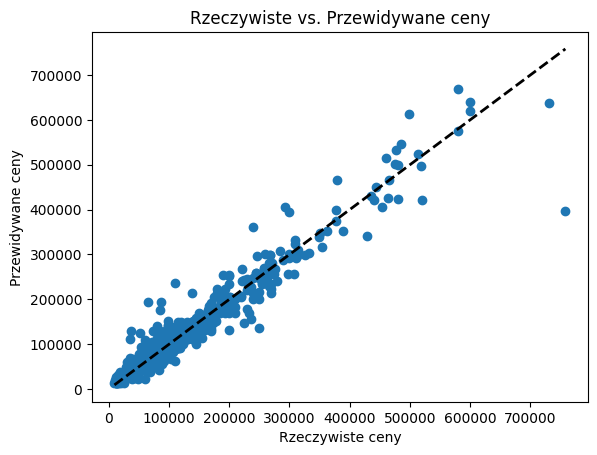

In [10]:
# najmniejszy średni błąd dal xgboost z parametryzacją
# zrobmy dla niego pare wizualizacji
from graphs import real_vs_predicted_prices
real_vs_predicted_prices(y_pred, y_test.to_numpy())

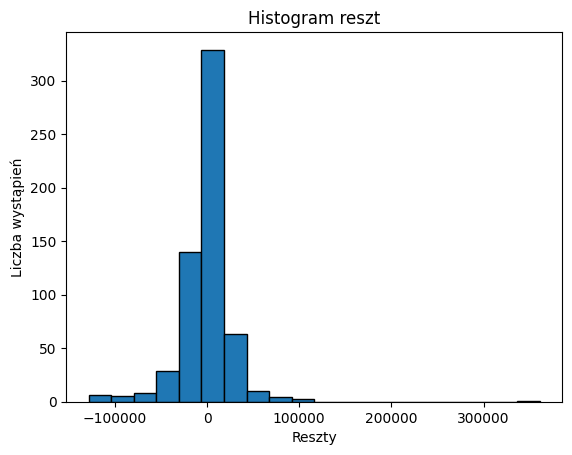

In [11]:
import graphs
graphs.residuals_hist(y_pred, y_test.to_numpy())

In [ ]:
import importlib
import graphs
importlib.reload(graphs)

graphs.feature_importances(X_test, grid_search)


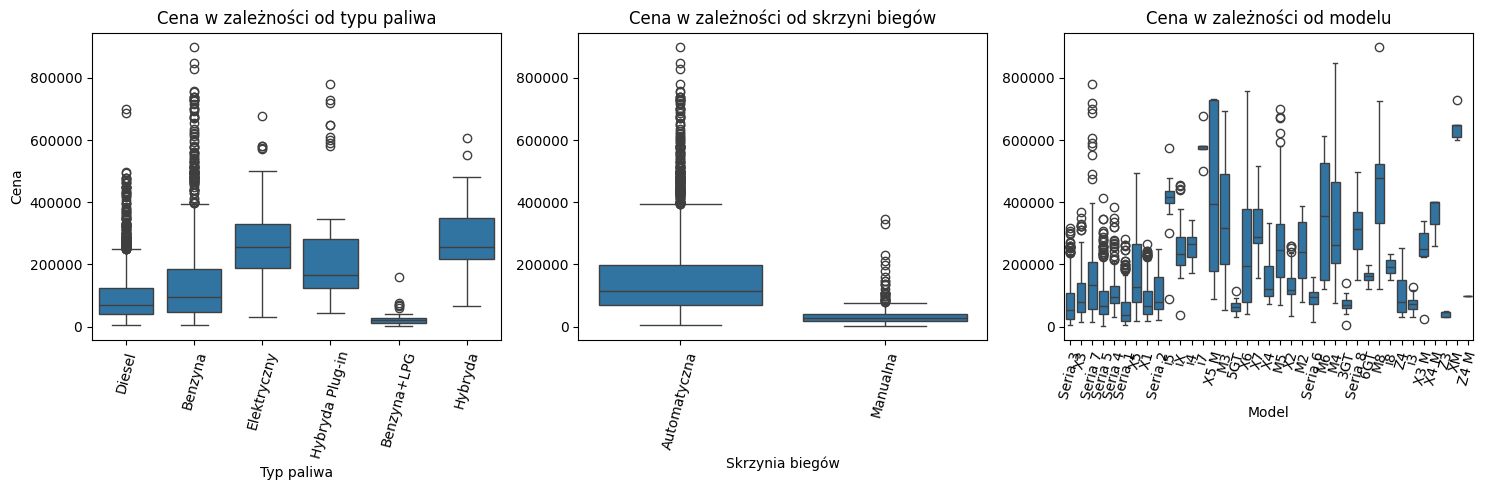

In [16]:
import importlib
import graphs
importlib.reload(graphs)

graphs.plot_categorical_boxplots(df)

In [20]:
import importlib
import graphs
importlib.reload(graphs)

graphs.plot_shap(grid_search, X_test)

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.